## Implementation with FLOWER

In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

In [443]:
plt.rcParams["figure.figsize"] = (25,15)

In [444]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [445]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [446]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0)

In [447]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [448]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [449]:
# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [303]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [304]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [305]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [306]:
timesteps = 13 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14078, 13, 1)

In [307]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [308]:
# Training
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.3, verbose=1)
model.summary()

Epoch 1/100
308/308 [==============================] - 5s 8ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 2/100
308/308 [==============================] - 2s 6ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 3/100
308/308 [==============================] - 2s 8ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/100
308/308 [==============================] - 3s 10ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 5/100
308/308 [==============================] - 2s 7ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 6/100
308/308 [==============================] - 2s 7ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/100
308/308 [==============================] - 2s 7ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/100
308/308 [==============================] - 2s 6ms/step -

In [309]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

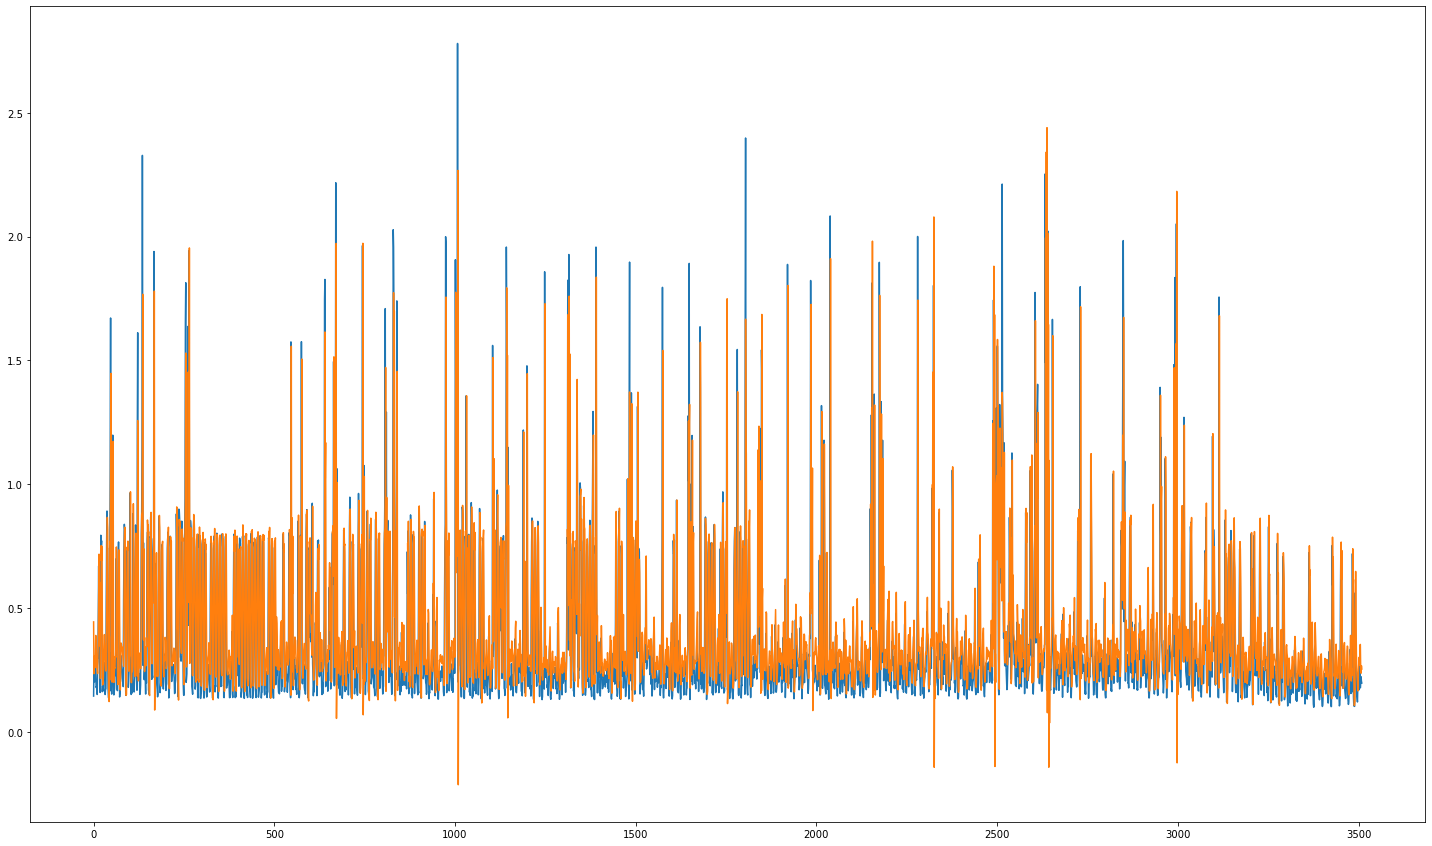

In [310]:
#plt.plot(pred_train['simple_lstm'])
plt.plot(pred_test['true'])
plt.plot(pred_test['simple_lstm'])
plt.show()


In [311]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [312]:
rmse_train={}
rmse_test={}

In [313]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [314]:
rmse_train

{'naive': 0.24255306635865367}

In [315]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [316]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [317]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [318]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [319]:
train, test = scale(train, test)

In [320]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [321]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [322]:
history=stateless_multilayer.fit(X_train, y_train, batch_size=32,epochs=30, validation_split=0.3 )

Epoch 1/30
308/308 [==============================] - 9s 15ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/30
308/308 [==============================] - 3s 11ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 3/30
308/308 [==============================] - 4s 14ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4/30
308/308 [==============================] - 3s 10ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 5/30
308/308 [==============================] - 3s 10ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 6/30
308/308 [==============================] - 3s 10ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 7/30
308/308 [==============================] - 3s 10ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 8/30
308/308 [==============================] - 3s 10ms/step - 

In [323]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

<AxesSubplot:>

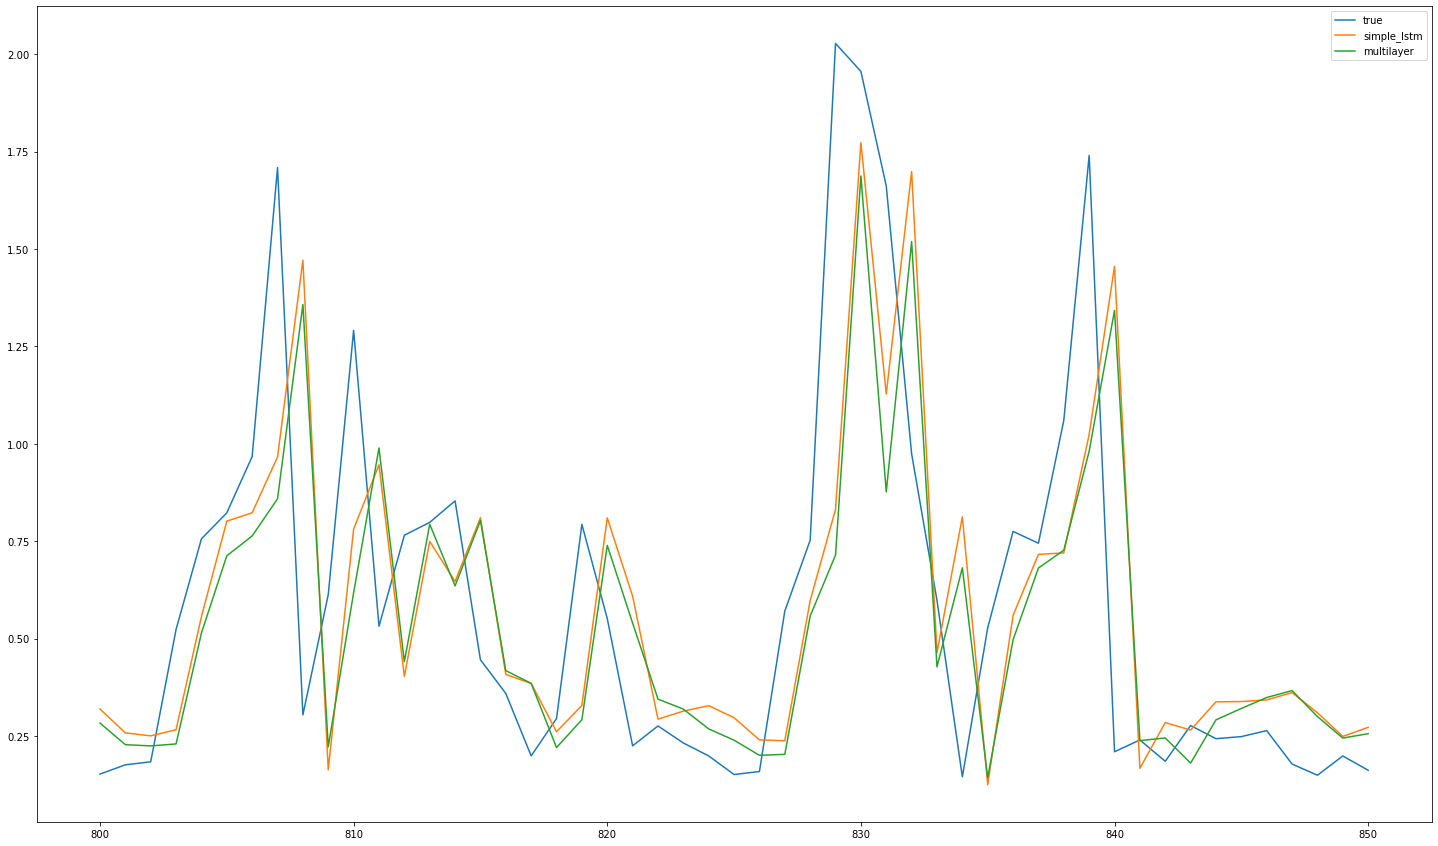

In [324]:
pd.DataFrame(pred_test).loc[800:850,].plot()

In [325]:
rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["multilayer"])

In [326]:
rmse_train

{'naive': 0.24255306635865367, 'stateless_multilayer': 0.2398229055971724}

In [327]:
rmse_test

{'naive': 0.2962993203699633, 'stateless_multilayer': 0.28359863290281595}

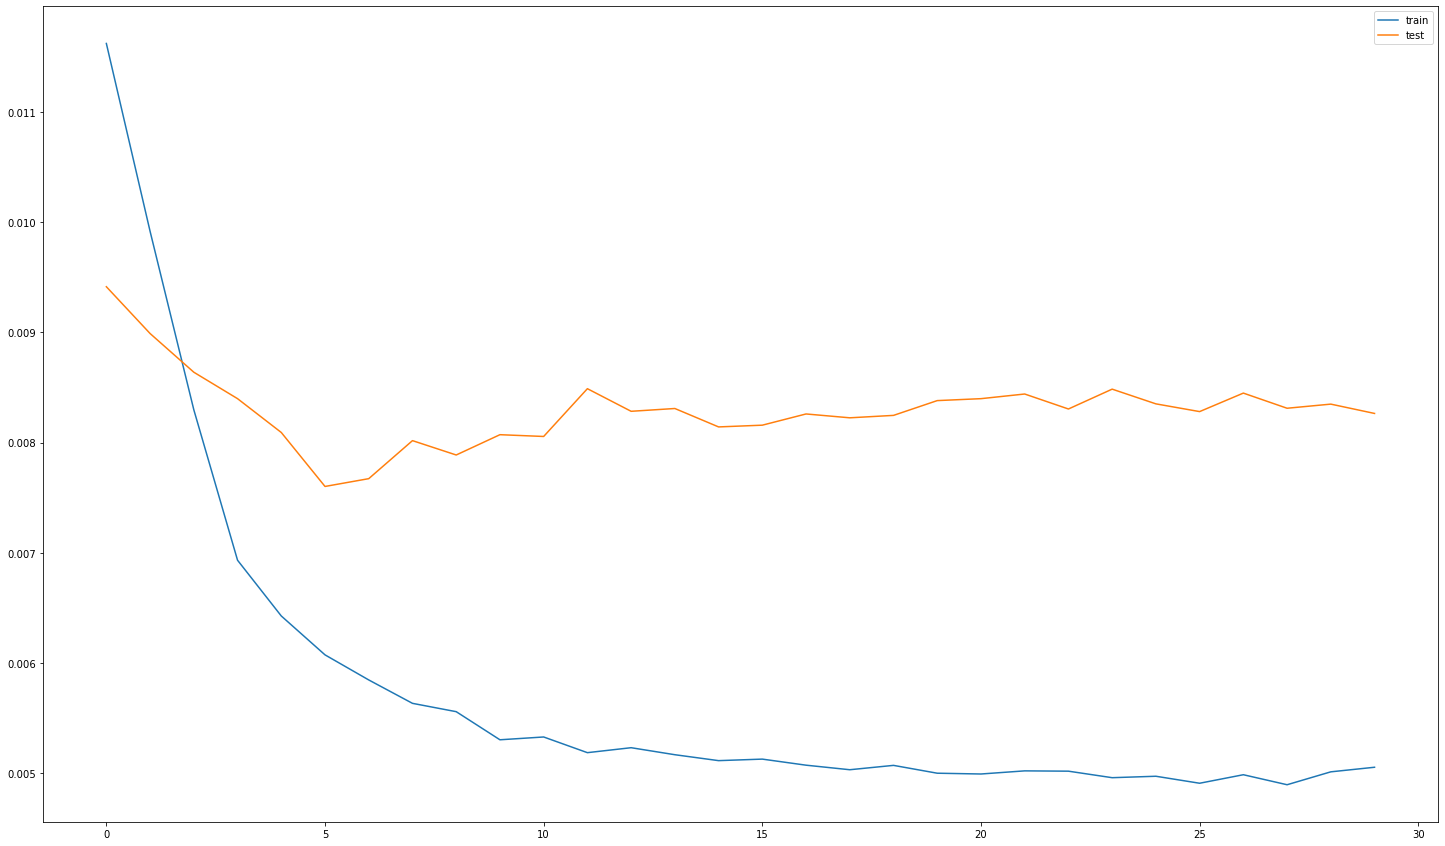

In [328]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Multivariate Time Series forecasting with LSTMS

The approach for multivariate Time series forecasting consists of using a lagged version of all features to predict the present value of the target variable

In [498]:
example = homes

In [499]:
values = example.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [500]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [501]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1, dropnan=False)

In [502]:
# drop columns we don't want to predict
reframed =reframed.iloc[:,:-6]

In [503]:
reframed= reframed.iloc[1:,:]

In [510]:
reframed= reframed.drop('var7(t-1)', axis=1)

<AxesSubplot:>

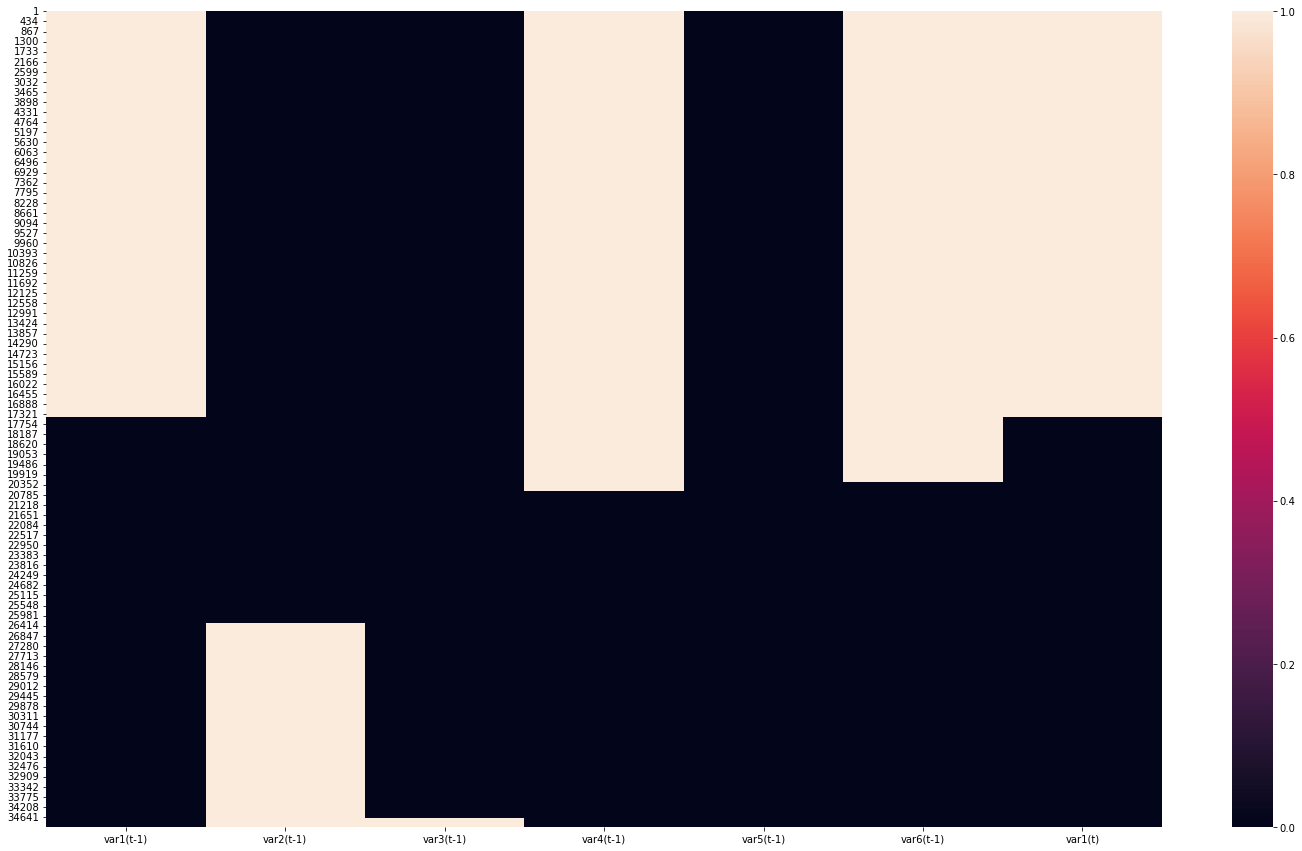

In [511]:
import seaborn as sns
sns.heatmap(reframed.isna())

In [512]:
reframed= reframed.dropna()

In [515]:
# split into train and test sets
values = reframed.values

train, test = train_test_split(values, train_size=0.8, shuffle=False)


In [516]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test =test[:, :-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4529, 1, 6) (4529,) (1133, 1, 6) (1133,)


In [519]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [343]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = keras.layers.LSTM(50)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm_19 (LSTM)              (None, 50)                11600     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


In [526]:
# fit network
history = model.fit(X_train, y_train, epochs=30, batch_size=24, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/30
189/189 - 1s - loss: 0.0257 - val_loss: 0.0735 - 591ms/epoch - 3ms/step
Epoch 2/30
189/189 - 1s - loss: 0.0258 - val_loss: 0.0739 - 617ms/epoch - 3ms/step
Epoch 3/30
189/189 - 1s - loss: 0.0257 - val_loss: 0.0726 - 550ms/epoch - 3ms/step
Epoch 4/30
189/189 - 0s - loss: 0.0258 - val_loss: 0.0729 - 476ms/epoch - 3ms/step
Epoch 5/30
189/189 - 1s - loss: 0.0258 - val_loss: 0.0727 - 505ms/epoch - 3ms/step
Epoch 6/30
189/189 - 1s - loss: 0.0257 - val_loss: 0.0719 - 539ms/epoch - 3ms/step
Epoch 7/30
189/189 - 1s - loss: 0.0256 - val_loss: 0.0720 - 501ms/epoch - 3ms/step
Epoch 8/30
189/189 - 0s - loss: 0.0257 - val_loss: 0.0728 - 494ms/epoch - 3ms/step
Epoch 9/30
189/189 - 0s - loss: 0.0256 - val_loss: 0.0719 - 489ms/epoch - 3ms/step
Epoch 10/30
189/189 - 0s - loss: 0.0256 - val_loss: 0.0708 - 486ms/epoch - 3ms/step
Epoch 11/30
189/189 - 0s - loss: 0.0258 - val_loss: 0.0725 - 488ms/epoch - 3ms/step
Epoch 12/30
189/189 - 0s - loss: 0.0257 - val_loss: 0.0703 - 492ms/epoch - 3ms/step
E

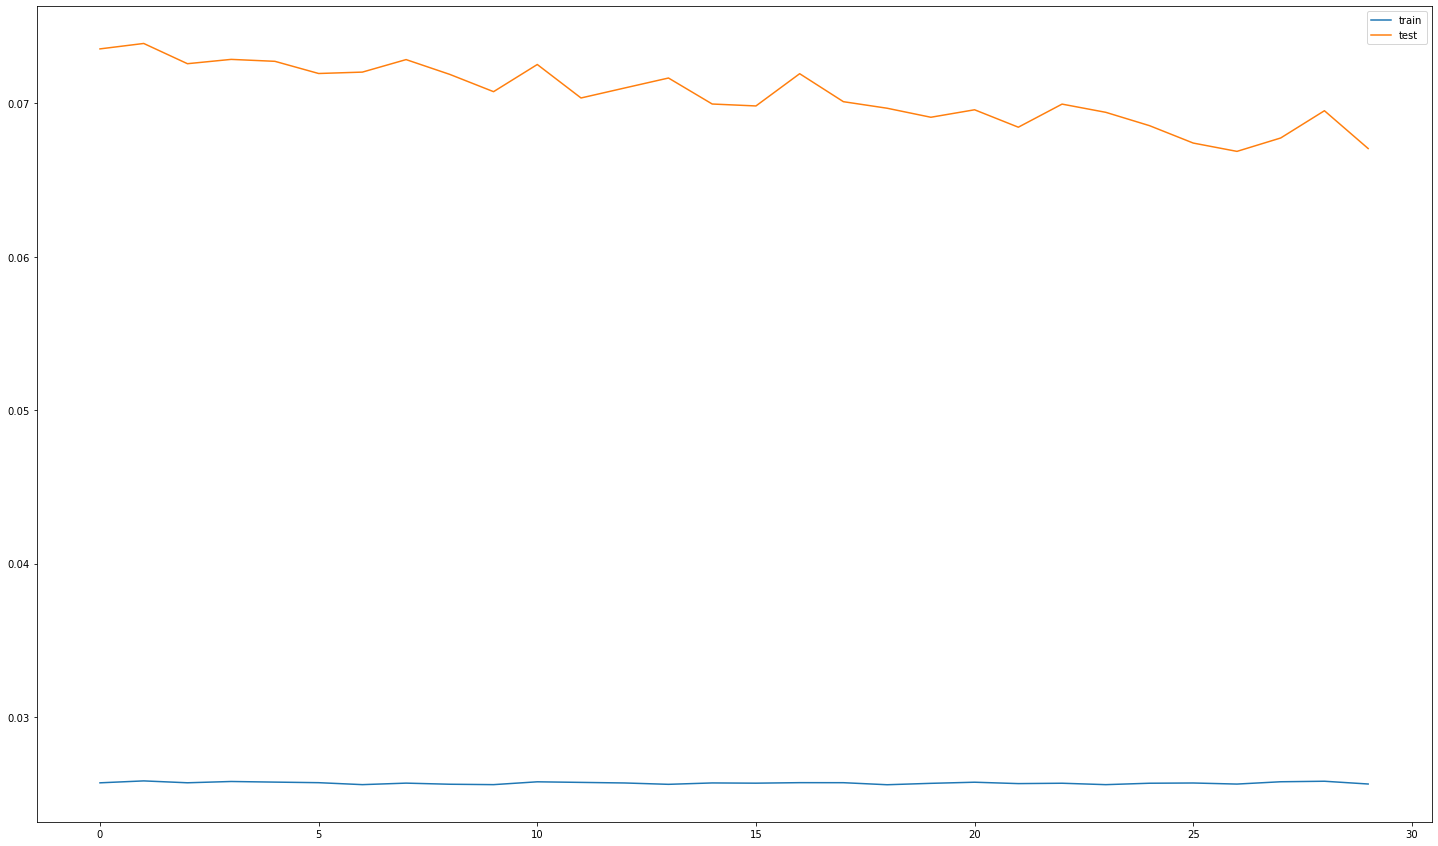

In [527]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [528]:
# make a prediction
yhat = model.predict(X_test)


In [530]:
X_test.shape

(1133, 1, 6)

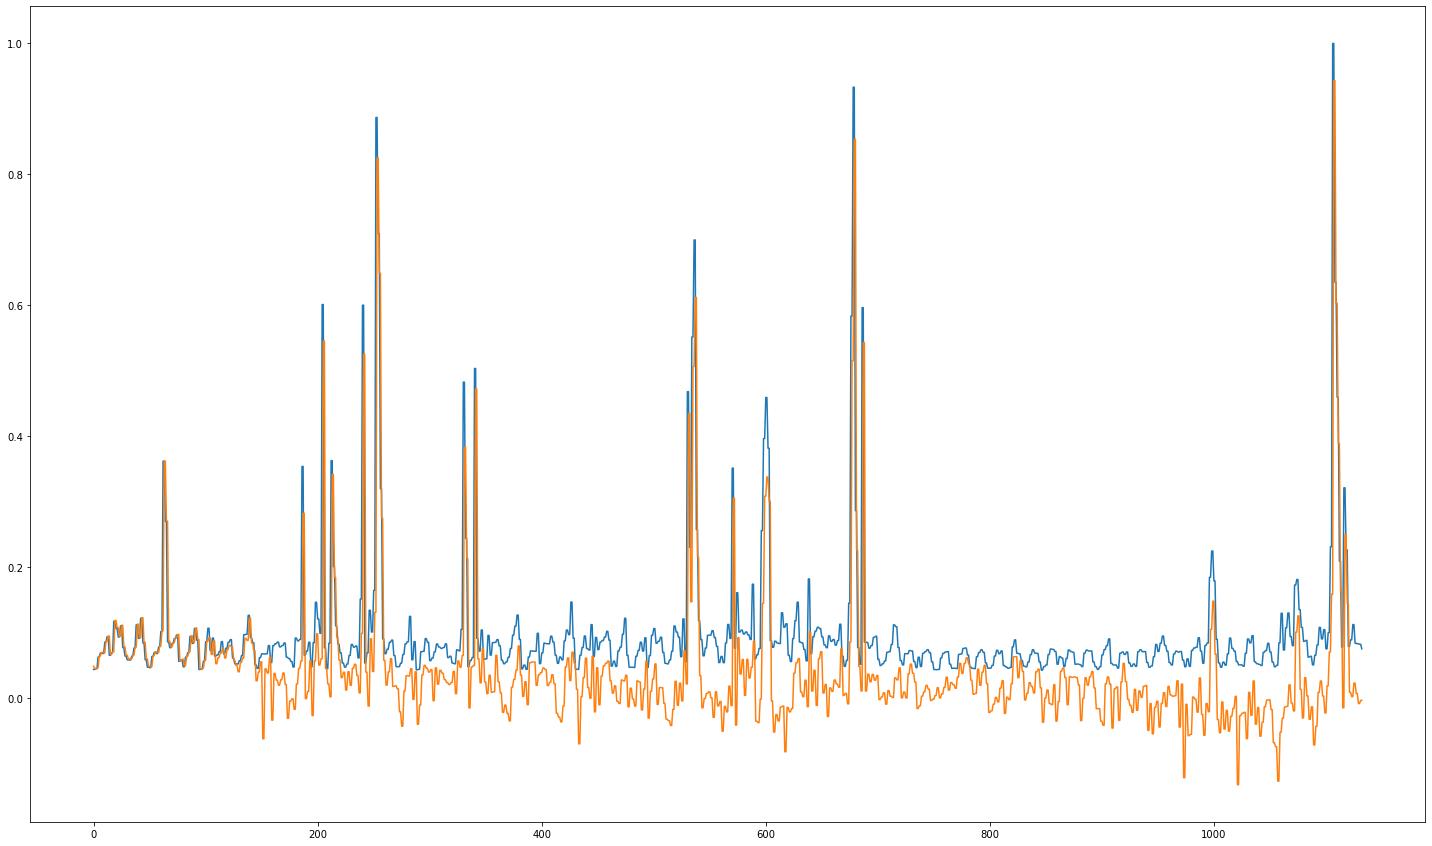

In [536]:
plt.plot(y_test)
plt.plot(yhat)

In [537]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))


In [540]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((test_y, X_test[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.315


In [280]:
X_test.shape

(3523, 1, 7)

In [348]:
from tensorflow import keras

In [350]:
# Another approach
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


In [355]:
data= example.values

In [356]:
X = np.arange(100)
Y = X*2

sample_length = 20
input_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
  X, None, sequence_length=sample_length, sequence_stride=sample_length)
target_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
  Y, None, sequence_length=sample_length, sequence_stride=sample_length)

for batch in zip(input_dataset, target_dataset):
  inputs, targets = batch
  assert np.array_equal(inputs[0], X[:sample_length])

  # second sample equals output timestamps 20-40
  assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
  break

In [357]:
input_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, None), dtype=tf.int64, name=None)>

## Example from machinelearningmastery

In [488]:
data= "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"

In [489]:
import datetime
from sklearn.preprocessing import LabelEncoder
# load dataset
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv(data)



In [490]:
dataset= dataset.iloc[:,5:]

In [491]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

      pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                           
24        129.0  -16  -4.0  1020.0      SE     1.79     0     0
25        148.0  -15  -4.0  1020.0      SE     2.68     0     0
26        159.0  -11  -5.0  1021.0      SE     3.57     0     0
27        181.0   -7  -5.0  1022.0      SE     5.36     1     0
28        138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [492]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])


In [493]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [496]:
train_X[0:10]

array([[[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
         0.00229001, 0.        , 0.        ]],

       [[0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
         0.00381099, 0.        , 0.        ]],

       [[0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
         0.00533197, 0.        , 0.        ]],

       [[0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
         0.00839101, 0.03703704, 0.        ]],

       [[0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
         0.00991199, 0.07407407, 0.        ]],

       [[0.10965794, 0.48529413, 0.21311474, 0.5636368 , 0.6666667 ,
         0.01143297, 0.11111111, 0.        ]],

       [[0.1056338 , 0.48529413, 0.21311474, 0.5818176 , 0.6666667 ,
         0.01449201, 0.14814815, 0.        ]],

       [[0.12474848, 0.48529413, 0.22950819, 0.6000004 , 0.6666667 ,
         0.01755106, 0.        , 0.        ]],

       [[0.12072434, 0.47058827, 0.21311474, 0.6000004 , 0.66666

In [ ]:
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)